# Case 6: Deep Learning and the Higgs Dataset


#### Steven Hayden, Kevin Mendonsa, Joe Schueder, Nicole Wittlin  

## Introduction 

In the field of *high energy physics*, observing exotic particles and measuring their properties may yield critical insights about the nature of matter. However, the data for analyzing these exotic particles is extremely sparse. For example, the Large Hadron Collider produces approximately 10^11 collisions per hour, yet only roughly 300 of these collisions result in the desired exotic particles. Therefore, good data analysis depends on distinguishing collisions which produce particles of interest (signal) from those producing other particles (background).

Machine learning, and specifically signal-versus-background classification, can aid in the analysis process. In 2014, Baldi et al. published the results of their work in "Searching for Exotic Particles in High-Energy Phyics with Deep Learning" to highlight how neural networks and deep learning approaches can improve the collider searches for exotic particles. 

Our objective is to recreate the neural network specifications used by Baldi and team leveraging updated techiques, as well as suggest improvements on their existing work given the advances in deep learning in the past six years.  

## Data Preparation and Exploratory Analysis

Baldi and team published a dataset of 11 million simulated collision events for benchmarking machine learning classification algorithms in distinguishing exotic particles (known as Higgs bosons). This data was produced using a Monte Carlo simulation and has 28 features: the first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator and the last seven features are high-level features derived by physicists from the first 21 features to help discriminate between the two classes. This dataset is known as the Higgs data.

The data set used in the Baldi analysis was nearly balanced with 53% positive examples in Higgs data. 

We did not conduct true data exploration on the data set; instead, we focused on confirming we had the correct information in a usable format. We opted to import the data as a dataframe, rather than a tensor. This choice made the data more readable and allowed for more straightforward analysis. We acknowledge that this may have a negative impact on performance.

### Package Set Up

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.3.0


In [7]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [8]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

### Data Set Preparation

In [10]:
import os
proxy = ''
os.environ['http_proxy'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [11]:
import pandas as pd
import requests
from io import StringIO

In [12]:
url_dataset = '/home/jjschued/HIGGS.csv'
#df = pd.read_csv('C:/Users/shayden/Downloads/HIGGS.csv.gz', compression = 'gzip',nrows=11000, header = None)
#url_dataset = 'C:/Users/shayden/Downloads/HIGGS.csv'
#df = pd.read_csv(url_dataset, nrows=1000000)
df = pd.read_csv(url_dataset)

In [13]:
url_dataset

'/home/jjschued/HIGGS.csv'

### Data Review

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 29 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   1.000000000000000000e+00    float64
 1   8.692932128906250000e-01    float64
 2   -6.350818276405334473e-01   float64
 3   2.256902605295181274e-01    float64
 4   3.274700641632080078e-01    float64
 5   -6.899932026863098145e-01   float64
 6   7.542022466659545898e-01    float64
 7   -2.485731393098831177e-01   float64
 8   -1.092063903808593750e+00   float64
 9   0.000000000000000000e+00    float64
 10  1.374992132186889648e+00    float64
 11  -6.536741852760314941e-01   float64
 12  9.303491115570068359e-01    float64
 13  1.107436060905456543e+00    float64
 14  1.138904333114624023e+00    float64
 15  -1.578198313713073730e+00   float64
 16  -1.046985387802124023e+00   float64
 17  0.000000000000000000e+00.1  float64
 18  6.579295396804809570e-01    float64
 19  -1.0454569943249225

In [18]:
dfx = df.rename(columns={x:y for x,y in zip(df.columns,range(0,len(df.columns)))})

## Replicating the Original Model 

Baldi and team chose optimal hyper-parameters for the deep learning neural network using a subset of the Higgs data consisting of 2.6M training examples and 100,000 validation examples. They note that the computational costs of the process did not allow for thorough optimization; however they combined pre-training methods, network architectures, initial learning rates, and regularization methods to determine the best criteria. 

The hyper-parameter optimization was performed using the full set of Higgs features, and the various classifiers algorithms.  These classifiers were tested on 500,000 simulated examples generated using Monte Carlo procedures as training sets. The best performing model, as determined by the Receiver Operating Characteristic (ROC) curves is outlined below. 

**Optimal Model from Baldi and team**
- Five-layer Neural Network with 300 hidden units in each layer
- Learning Rate of 0.05
- Weight Decay Coefficient 1 x 10-5
- Predetermined without Optimization  
    - Hidden units all used the **tahn** activation function
    - Weights initialized from normal distribution with 0 mean and standard deviation 0.1 in first layer, 0.001 in output layer, and 0.05in all other hidden layers
    - Mini-batches of size 100 to compute gradients
    - Momentum increased linearly over the first 200 epochs from 0.9 to 0.99, then remained constant
    - Learning Rate decayed by 1.0000002 every batch update until it reached a minimum of 10-6
- Training ended when momentum reached maximum value and minimum error on validation set of 500,000 examples had not decreased by more than a factor of 0.00001 over 10 epochs. Early stopping prevented overfitting and each NN trained over 200-1000 epochs.
- When training with dropout, increased learning rate decay to 1.0000003 and ended training when the momentum reached maximum value and error on validation set had not decreased for 40 epochs
- Inputs standardized over entire train/test set with mean 0 and standard deviation of 1, except for features with values strictly greater than 0 (scaled for mean value of 1)
- An additional boost in performance is obtained by using the dropout training algorithm, in which we stochastically drop neurons in the top hidden layer with 50% probability during training.


In [17]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [104]:
#def schedule( lr):
#   if lr > 0.000001:
#       return float(lr)
#   else:
#       return float(0.000001)

    
# learning rate schedule
def schedule(epoch,lr):
    initial_learning_rate=0.05
    decay = 0.0000002
    decay_steps= float(STEPS_PER_EPOCH*1000)
    if lr > 0.000001:
        LearningRate = initial_learning_rate / (1 + decay * epoch/ decay_steps)  
        print(epoch)              
        return float(LearningRate)
    else:
        LearningRate=float(0.000001)
        print(epoch)
        return LearningRate
    
   
    
def get_callbacks():
    
  return [
#    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', min_delta = 0.00001, mode = 'min', patience=10),
    tf.keras.callbacks.LearningRateScheduler(schedule)
  ]

In [105]:
def get_optimizer():
    
  return tf.keras.optimizers.SGD(learning_rate=0.05,momentum=0.90, decay = 0.0000002, nesterov=True)

In [106]:
#Parms needed for case study  

#We selected a five-layer neural network with 300 hidden units in each layer,
#a learning rate of 0.05, and a weight decay coefficient of 1 × 10−5.
# Hidden layer have tanh activation function
#Gradient computations were made on mini-batches of size 100
#The learning rate decayed by a factor of 1.0000002 every batch update until it reached a minimum of 10^−6,

def define_predictor():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(300, kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None), input_shape= X_train.shape[1:], activation='tanh')) # Hidden 1
    model.add(layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(300,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh')) # Hidden 2
    model.add(tf.keras.layers.Dense(300,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh')) # Hidden 3
    model.add(tf.keras.layers.Dense(300,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh')) # Hidden 4
    model.add(tf.keras.layers.Dense(300,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh')) # Hidden 5
    model.add(tf.keras.layers.Dense(1,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001, seed=None),activation='sigmoid')) # Output #1.2
    #model.add(tf.keras.layers.Dense(1,activation='softmax')) # Output
    #sgd = tf.keras.optimizers.SGD(lr=.05, decay = 1.0000002, momentum=0.99)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=get_optimizer() , 
                  metrics=['accuracy', 
                            tf.keras.losses.BinaryCrossentropy(
                            from_logits=True, name='val_binary_crossentropy'), 
                            tf.keras.metrics.AUC()])
    return model

    
#setup scaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
dfx
X = dfx.loc[:, 1:28]
Y = dfx[0].copy()
y = Y.values

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn import metrics as mt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size = 0.5, random_state = 101)
#N_VALIDATION = int(1e3)

BATCH_SIZE = 3000




### Hyper-parameters

**Hidden layers** - help models extrapolate relationships between variables. One hidden layer is enough to estimate first order and second order interactions. The larger the number of hidden layers in a neural network, the longer it will take for the neural network to produce the output and the more complex problems the neural network can solve. Due to the complexity of our problem additional hidden layers were needed. 

**Epoch** – represents the number of completes passes through the training dataset during the learning process, where the learning algorithm loops through a fixed number of epochs and within each, updates the network for each row in the training data; one epoch means that each sample in the training dataset has updated internal parameters; calculated as N / batch size training iterations, where N is the total number of examples. 

*“You can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified “batch size” number of samples.”* - Jason Brownlee, PhD, https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

**Iteration** – number of batches needed to complete on epoch

**Understanding Iterations, Batches, and Epochs**

Dataset with 200 samples<br>
Batch size = 5<br>
Epochs = 1000
- Dataset will be divided into 40 batches, each with 5 samples, model weights will update after each batch of 5 samples
- One epoch will involve 40 batches/40 updates to model
- 1000 epochs, model will be exposed/passed through whole data 1000 times, total of 40,000 batches during entire training process

**Batch/batch size** – the number of data points/observations used in one iteration (one gradient update) of model training and dictates the number of training observations to be “learned” before updating internal parameters; generally, a larger batch involves more training examples, thus yielding a more stable learning process and accurate estimate. For example, a batch size of 32 means that 32 samples from the training dataset will be used to estimate error gradient before the model weights are updated. *NOTE: batch size and number of batches are different.* 

**Learning Rate** – a configurable hyper-parameter that controls how quickly/slowly a neural network learns a problem, more specifically it controls how much to change the weights to correct for error during each iteration; a large learning rate allows model to train faster but a cost, where smaller learning rates may yield a better model, requiring more training epochs and smaller batch sizes. 
- Math: gradient descent algorithm multiples learning rate by gradient, for example value of 0.1 will update weight 10% of the amount it could be updated
- Range: 0.0 to 1.0, traditional default 0.1 or 0.01

**Learning Rate Decay** – how learning rate changes over training epochs; learning rate decay can be designed where large weight changes happen at the beginning of the process and smaller, fine-tune changes toward the end; another strategy is to decay over a fixed number of training epochs at a small, constant value.

**Drop Out** – form of regularization to minimize overfitting; technique that randomly removes/inactivates neurons at each training step, which forces remaining neurons to be more independent because they learn rated not in conjunction/cooperation with neighboring neuron; roughly doubles the number of iterations required for convergence but training time for each epoch is less.

**Activation Functions** – aka transfer functions; functions that take a weighted sum of all inputs from previous layer and generates an output value for the next layer; for each node, it defines the output of the node given an input or set of inputs. 
- Tanh activation – a non-linear activation function that outputs values between -1.0 and 1.0 and the center falls around 0; limitations are that it can have limited sensitivity and is prone to saturation in larger, more layered networks due to vanishing gradients.
- Sigmoid activation – a non-linear activation function similar to a logistic function, where inputs produce a result between 0 and 1; sigmoid outputs are not centered around 0; not necessarily good for many layered networks due to vanishing gradients, and drawbacks include it can be prone to saturation and kill gradient movement.
![title](img/tanh.png) 

**Gradient Descent** - A method for looking for minimum or maximum values for a parameter.  The data is evaluatied in computations to determine if the current comutation is moving towards the goal minimum or maximum compared to the last computation.   

**Types of Gradient Descent** 
- **Batch Gradient Descent** – batch size is set to total number of examples in the training dataset
- **Stochastic Gradient Descent** – batch size is set to one
- **Minibatch Gradient Descent** – batch size is set to more than one and less than the total number of examples in the training dataset. 

**Stochastic Gradient Descent Parameters**
 - **Nesterov** - In the standard Momentum method, the gradient is computed using current parameters. Nesterov momentum achieves stronger convergence by applying the velocity to the parameters in order to compute interim parameters. These interim parameters are then used to compute the gradient, called a "lookahead" gradient step. (https://golden.com/wiki/Nesterov_momentum ) 
 - **Momentum** - Determines how much previous gradients effect the current iteration. Ususally this is set to .9 which allows the model to make large leaps when moving in one direction, but decreases when the most recent result finds a change in direction. It im improves the speed of optimization in concert with step size by helping SGD algorithm navigate in relevant/optimal directions; in other words, it adds inertia to the algorithm update process to continue moving in the optimal direction; best to begin with smaller momentum and then increase after passing through larger gradients – momentum can cause learning process to miss or oscillate around the minima. 
- Math: adds a fraction of the direction of the previous step to a current step
- Range: 0.0 to 1.0, traditional default 0.9, 0.99 or 0.5 

In [107]:
Att_model = define_predictor()
history = Att_model.fit(scaler.fit_transform(X_train),
                        np.array(y_train),
                        callbacks=get_callbacks(),
                        verbose=2, 
#                        steps_per_epoch = 5, 
                        epochs=50, 
                        batch_size=BATCH_SIZE,
                        validation_data =  ( X_validate, y_validate ))

0
Epoch 1/50
2567/2567 - 22s - loss: 0.5829 - accuracy: 0.6859 - val_binary_crossentropy: 0.6689 - auc_8: 0.7548 - val_loss: 0.6713 - val_accuracy: 0.5858 - val_val_binary_crossentropy: 0.6929 - val_auc_8: 0.6267
1
Epoch 2/50
2567/2567 - 21s - loss: 0.5260 - accuracy: 0.7324 - val_binary_crossentropy: 0.6479 - auc_8: 0.8117 - val_loss: 0.6641 - val_accuracy: 0.6183 - val_val_binary_crossentropy: 0.6956 - val_auc_8: 0.6373
2
Epoch 3/50
2567/2567 - 21s - loss: 0.5142 - accuracy: 0.7402 - val_binary_crossentropy: 0.6439 - auc_8: 0.8213 - val_loss: 0.6807 - val_accuracy: 0.6172 - val_val_binary_crossentropy: 0.6988 - val_auc_8: 0.6280
3
Epoch 4/50
2567/2567 - 21s - loss: 0.5085 - accuracy: 0.7442 - val_binary_crossentropy: 0.6419 - auc_8: 0.8259 - val_loss: 0.7055 - val_accuracy: 0.6017 - val_val_binary_crossentropy: 0.7063 - val_auc_8: 0.6238
4
Epoch 5/50
2567/2567 - 21s - loss: 0.5049 - accuracy: 0.7467 - val_binary_crossentropy: 0.6407 - auc_8: 0.8287 - val_loss: 0.6816 - val_accuracy: 

In [96]:
results = Att_model.evaluate(scaler.fit_transform(X_test),np.array(y_test), batch_size=100)

16500/16500 [==============================] - 40s 2ms/step - loss: 0.4688 - accuracy: 0.7705 - val_binary_crossentropy: 0.6265 - auc_7: 0.8557


In [97]:
predictions = Att_model.predict(scaler.fit_transform(X_test))

In [98]:
preddf = pd.DataFrame(predictions)
preddf.head()

,0
0,0.902757
1,0.704698
2,0.401465
3,0.593673
4,0.599746


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

preddf['round'] = preddf.round(preddf[0])

yresultsround = preddf['round'].tolist()
yresultsround[2]
y_test.shape
y_test[2]

ybinary = label_binarize(y_test, classes=[0,1])
y_score = label_binarize(yresultsround, classes=[0,1])

### Computing Power Used to Train and Test Replicated Model

We used an AWS Deep Learning AMI. The AMIs provide machine learning practitioners and researchers with the infrastructure and tools to accelerate deep learning in the cloud, at any scale. You can quickly launch Amazon EC2 instances(servers) pre-installed with popular deep learning frameworks and interfaces such as TensorFlow, PyTorch, Apache MXNet, Chainer, Gluon, Horovod, and Keras to train sophisticated, custom AI models, experiment with new algorithms, or to learn new skills and techniques.  (https://aws.amazon.com/machine-learning/amis/)

The server we utlized was an Amazon EC2 G3. The G3 instances are the latest generation of Amazon EC2 GPU graphics instances that deliver a powerful combination of CPU, host memory, and GPU capacity. G3 instances are ideal for graphics-intensive applications such as 3D visualizations, mid to high-end virtual workstations, virtual application software, 3D rendering, application streaming, video encoding, gaming, and other server-side graphics workloads.  

Our specific instance  has 32 vCPUs based on custom 2.7 GHz Intel Xeon E5 2686 v4 processors and 244 GiB of DRAM host memory. Backed by2 NVIDIA Tesla M60 GPUs, with each GPU delivering up to 2,048 parallel processing cores and 8 GiB of GPU memory. (https://aws.amazon.com/ec2/instance-types/g3/)

| Name | GPUs | vCPU | Memory (GiB) | GPU Memory (GiB) |
|-|-|-|-|-|
| g3.8xlarge | 2 | 32 | 244 | 16 |

### Comparison Metrics

**Training, Evaluation and Testing Data** - Our ratio of train vs validation/test size was 70% to 30%. Of the 30% held back for validation and test, 50% was allocated to each. This generally follows using 80% or less to train with in order to avoid overfitting. 

In the paper, Baldi and team produced Receiver Operating Characteristic (ROC) curves to illustrate performance of the models, using the area under the ROC curve (AUC) as the measurement metric. This metric is directly related to classiciation accuracy and correlated to other metrics. Thus is a solid choice for comparison in this scenario. 

With AUC, larger values indicate higher classification accuracy, so our goal is to obtain higher values. From the paper, it appears they achieved an **AUC score of 0.88** for both the low-level feature set and the complete feature set when utilizing the dropout training algorithm (stochastically dropping neurons in the top hidden layer with 50% probablity during training). (We are most interested in the complete feature set as we used all the features in our comparative analysis). For our results, we were able to obtain an **AUC score of 0.8556 on the validation data** and an **AUC score of 0.8556 on prediction data**. 

#### Validation ROC:

AUC of ROC Curve: 0.8555619018456299


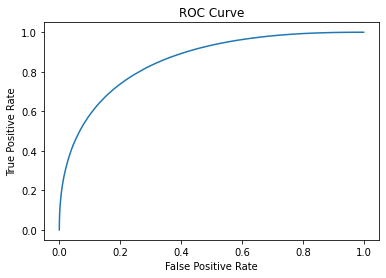

In [103]:
import sklearn as sk
#Calculate the scores using the first model (replica)
 
scores_1 = Att_model.predict(scaler.fit_transform(X_validate))

fpr, tpr, thresholds = sk.metrics.roc_curve(y_validate, scores_1)

#Display the ROC score and plot
roc_auc = sk.metrics.roc_auc_score(y_validate, scores_1)

print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

#### Prediction ROC:

AUC of ROC Curve: 0.8556648679350376


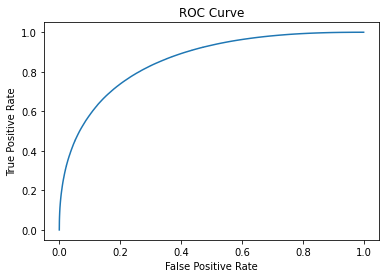

In [101]:
import sklearn as sk
#Calculate the scores using the first model (replica)
scores_1 = Att_model.predict(scaler.fit_transform(X_test))

fpr, tpr, thresholds = sk.metrics.roc_curve(y_test, scores_1)

#Display the ROC score and plot
roc_auc = sk.metrics.roc_auc_score(y_test, scores_1)

print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

## Now vs Then: Best Practices and Recommendations

### Idea 1: Explore New Python Packages and Other Software
Today, there are newer packages that require a lot less effort and are more efficient than **TensorFlow** and **Keras**. TensorFlow is an end to end open-source library used for machine learning and neural networks that are simple to understand, but does not allow for much flexibility as some of the newer APIs. 

PyTorch is becoming one of the more popular packages out there. PyTorch is a Python-based scientific computing package that combines the flexibility of NumPy arrays with the power to use GPUs. (PyTorch tensors are similar to NumPy arrays.) It is designed to provide maximum flexibility and speed. PyTouch is model to be similar to Pandas, so the learning curve is much more gradual.



### Activation Functions: We would explore using the newer activation functions of ReLU, Softwmax vs tanh or Sigmoid.


**Softmax activation** – "This function converts numbers to probabilities that sum up to one. It outputs a vector that denotes the probability distributions of a list of potenmtial outcomes"
![title](img/Softmax.png) 

Reference: https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d#:~:text=Specifically%20trying%20out%20neural%20networks,a%20list%20of%20potential%20outcomes.

**Sigmoid activation** - "Sigmoid activation functions use a second non-linearity for large inputs. Being in the range from zero and one, sigmoid activations can be interpreted as probabilities. If a range from -1 to 1 is desired, the sigmoid can be scaled and shifted to yield the hyperbolic tangent activation function"
![title](img/Sigmoid.png) 

Reference: https://en.wikipedia.org/wiki/Activation_function#:~:text=Sigmoid%20activation%20functions%20use%20a,the%20hyperbolic%20tangent%20activation%20function%3A%20.

**tanh** - "tanh is similar to a logistic sigmoid but better. The range of the tanh function is from (-1 to 1). tanh is also sigmoidal (s - shaped). The advantage is that the negative inputs will be mapped strongly negative and the zero inputs will be mapped near zero in the tanh graph."
![title](img/tanh.png) 

Reference: https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6#:~:text=tanh%20is%20also%20like%20logistic,sigmoidal%20(s%20%2D%20shaped).&text=The%20advantage%20is%20that%20the,zero%20in%20the%20tanh%20graph.


**ReLU activation** – Rectified Linear Unit activation function, is a piecewise linear function that outputs the input directly if positive (otherwise, output 0). Default activation, easy train, better performance, activation is threshold at 0, can accelerate SGD, implemented by simply thresholding matrix of activations at 0, can be fragile where weights could update in a way for neuron to not activate again (Leaky ReLU attempts to fix dying problem)
![title](img/ReLU_vs_Sigmoid.png) 


### Sampling
- Training and Testing using different splits of the data. Baldi et al used 99% of the data for training and a 1% for testing.  We recommend using an 80% train and 20% test setbut other options such as 70/30 should also be explored.

### ADAM Optimizer
- "Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iteratively based on the training data."  We leveraged the Adam optimizer for our model but clearly given our accuracyt scores, more refinement is required to obtian the most optimal parameter settings.

Reference: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20an%20optimization%20algorithm,iterative%20based%20in%20training%20data.&text=The%20algorithm%20is%20called%20Adam.

## Conclusions

While we were able to leverage the use of different hyper-parameters and functions within Tensorflow and Keras, we were not able to achieve the same ROC scores per Baldi et al in their original paper. It is also evident that neural networks provides extensive functionality and power to build models of such complexity with relative ease and reduced coding. The key learning for us was the importance of **tuning** the hyper-parameters and therefore understanding their impact on model performance and execution. Learning rate and the time spent training had the highest impact. Most of the other parameters adjust how learning rate behaved through out the training process. We found that a large learning rate was needed to get model to increase accuracy at an acceptable rate.  We would increase the number of epochs to give the model more time find the minimum if we had more time and resources available to match Baldi’s research.